# Zero-Shoot

## Carga de datos

In [1]:
import pandas as pd

In [2]:
predicted_sql = pd.read_json('results/predicted_sql_zero_shot.json', orient='records')
ground_truth = pd.read_json('bird_db/ground_truth.json', orient='records')

In [3]:
predicted_sql.head()

,question_id,gemini_1.5_Flash,chatgpt_4mini
0,721,SELECT COUNT(DISTINCT superhero.id) AS num_sup...,SELECT COUNT(*) FROM superhero WHERE eye_colou...
1,777,SELECT gender.gender FROM superhero JOIN gende...,SELECT g.gender FROM superhero s JOIN gender g...
2,731,SELECT COUNT(DISTINCT superhero.id) AS num_dc_...,SELECT COUNT(*) FROM superhero WHERE publisher...
3,759,SELECT colour.colour FROM superhero JOIN colou...,SELECT eye_colour_id FROM superhero ORDER BY w...
4,837,SELECT hero_id FROM hero_attribute JOIN attrib...,SELECT hero_id FROM hero_attribute ORDER BY at...


In [4]:
ground_truth.head()

,question_id,ground_truth,difficulty
0,717,SELECT T3.power_name FROM superhero AS T1 INNE...,simple
1,718,SELECT COUNT(T1.hero_id) FROM hero_power AS T1...,simple
2,719,SELECT COUNT(T1.id) FROM superhero AS T1 INNER...,moderate
3,720,SELECT DISTINCT T1.full_name FROM superhero AS...,simple
4,721,SELECT COUNT(T1.id) FROM superhero AS T1 INNER...,simple


In [5]:
zero_shot = pd.merge(predicted_sql, ground_truth, on='question_id')
zero_shot = zero_shot.sort_values(by='question_id').reset_index(drop=True)

In [6]:
zero_shot.head()

,question_id,gemini_1.5_Flash,chatgpt_4mini,ground_truth,difficulty
0,717,SELECT superpower.power_name FROM superhero JO...,SELECT sp.power_name FROM superpower sp JOIN h...,SELECT T3.power_name FROM superhero AS T1 INNE...,simple
1,718,SELECT COUNT(*) FROM superhero JOIN hero_power...,SELECT COUNT(DISTINCT hp.hero_id) AS superhero...,SELECT COUNT(T1.hero_id) FROM hero_power AS T1...,simple
2,719,SELECT COUNT(*) FROM superhero s JOIN hero_pow...,SELECT COUNT(DISTINCT s.id) AS super_strength_...,SELECT COUNT(T1.id) FROM superhero AS T1 INNER...,moderate
3,720,SELECT superhero.full_name FROM superhero JOIN...,SELECT s.full_name FROM superhero s JOIN hero_...,SELECT DISTINCT T1.full_name FROM superhero AS...,simple
4,721,SELECT COUNT(DISTINCT superhero.id) AS num_sup...,SELECT COUNT(*) FROM superhero WHERE eye_colou...,SELECT COUNT(T1.id) FROM superhero AS T1 INNER...,simple


## Evaluación

In [42]:
import sqlite3
import time
import math
import re

db_path = 'bird_db/superhero.sqlite'

In [62]:
def exact_match(df, model):
    em = []

    for _, row in df.iterrows():
        predicted_sql = row[model]
        ground_truth = row['ground_truth']

        if predicted_sql == ground_truth:
            em.append(1)
        else:
            em.append(0)

    #print(f'Model: {model}')
    print('-------------------------------')
    print(f'EM - Total:\t\t{sum(em) / len(em) * 100:.2f} %')

    return em

In [63]:
def execution_acc(df, model, db_path):
    ex = []
    err = []

    with sqlite3.connect(db_path) as conn:
        for _, row in df.iterrows():
            predicted_sql = row[model]
            ground_truth = row['ground_truth']

            try:
                cursor = conn.cursor()
                cursor.execute(predicted_sql, ())
                predicted_res = cursor.fetchall()
                cursor.execute(ground_truth, ())
                ground_truth_res = cursor.fetchall()
                res = 0
                if set(predicted_res) == set(ground_truth_res):
                    res = 1
            except sqlite3.Error as e:
                #print(f"An error occurred: {e}")  # Print the error if something goes wrong
                #er = str(row['question_id']) + ': ' + str(e)
                res = 0
                
                #err.append(er)
            ex.append(res)

    #print(f'Execution Accuracy: {sum(ex) / len(ex) * 100:.2f} %')

    return ex #, err

In [96]:
def results_ex(results):
    #print(results['simple'])

    total_sum = sum([sum(valores) for valores in results.values()])
    total_count = sum([len(valores) for valores in results.values()])
    accuracy = (total_sum / total_count) * 100

    simple = (sum(results["simple"]) / len(results["simple"])) * 100
    moderate = (sum(results["moderate"]) / len(results["moderate"])) * 100
    challenging = (sum(results["challenging"]) / len(results["challenging"])) * 100
    total = (total_sum / total_count) * 100

    #print('-------------------------------')
    #print(f'EX - Simple:\t\t{simple:.2f} %')
    #print(f'EX - Moderate:\t\t{moderate:.2f} %')
    #print(f'EX - Challenging:\t{challenging:.2f} %')
    #print('-------------------------------')
    #print(f'EX - Total:\t\t{total:.2f} %')
    print(f'EX:\t{total:.2f} %')
    results = {
        'simple': simple,
        'moderate': moderate,
        'challenging': challenging,
        'total': total
        }
    
    return results

In [94]:
def execution_acc_by_diff(df, model, db_path):
    # Agrupar el dataframe por dificultad
    df_grouped = df.groupby('difficulty')

    # Inicializar un diccionario para almacenar los resultados
    results = {}

    # Iterar sobre los grupos de dificultad
    for difficulty, group in df_grouped:
        # Calcular la ejecución de precisión para cada grupo
        accuracy = execution_acc(group, model, db_path)

        # Almacenar los resultados en el diccionario
        results[difficulty] = accuracy

    # Devolver los resultados
    #print(f'Model: {model}')
    #results = results_ex(results)

    return results_ex(results)
    #return results #, errors

In [66]:
def valid_sql(df, model, db_path):
    ex = []
    err = []

    with sqlite3.connect(db_path) as conn:
        for _, row in df.iterrows():
            predicted_sql = row[model]
            ground_truth = row['ground_truth']

            try:
                cursor = conn.cursor()
                cursor.execute(predicted_sql, ())
                predicted_res = cursor.fetchall()
                cursor.execute(ground_truth, ())
                ground_truth_res = cursor.fetchall()
                res = 0
                if set(predicted_res) == set(ground_truth_res):
                    res = 1
                else:
                    res = 1
            except sqlite3.Error as e:
                #print(f"An error occurred: {e}")  # Print the error if something goes wrong
                #er = str(row['question_id']) + ': ' + str(e)
                res = 0
                
                #err.append(er)
            ex.append(res)

    #print(f'Execution Accuracy: {sum(ex) / len(ex) * 100:.2f} %')

    return ex #, err

In [97]:
def results_va(results):
    #print(results['simple'])

    total_sum = sum([sum(valores) for valores in results.values()])
    total_count = sum([len(valores) for valores in results.values()])

    simple = (sum(results["simple"]) / len(results["simple"])) * 100
    moderate = (sum(results["moderate"]) / len(results["moderate"])) * 100
    challenging = (sum(results["challenging"]) / len(results["challenging"])) * 100
    total = (total_sum / total_count) * 100

    #print('-------------------------------')
    #print(f'VA - Simple:\t\t{simple:.2f} %')
    #print(f'VA - Moderate:\t\t{moderate:.2f} %')
    #print(f'VA - Challenging:\t{challenging:.2f} %')
    #print('-------------------------------')
    #print(f'VA - Total:\t\t{total:.2f} %')
    print(f'VA:\t{total:.2f} %')

    results = {
        'simple': simple,
        'moderate': moderate,
        'challenging': challenging,
        'total': total
        }

    return results


In [90]:
def valid_sql_by_diff(df, model, db_path):
    # Agrupar el dataframe por dificultad
    df_grouped = df.groupby('difficulty')

    # Inicializar un diccionario para almacenar los resultados
    results = {}

    # Iterar sobre los grupos de dificultad
    for difficulty, group in df_grouped:
        # Calcular la ejecución de precisión para cada grupo
        accuracy = valid_sql(group, model, db_path)

        # Almacenar los resultados en el diccionario
        results[difficulty] = accuracy

    # Devolver los resultados
    #print(f'Model: {model}')
    
    
    return results_va(results)
    
    #results_va(results)
    #return results #, errors

In [100]:
def execute_sql(sql, db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    start_time = time.time()
    cursor.execute(sql)
    exec_time = time.time() - start_time
    #print(f'Execution time: {exec_time:.2f} seconds')
    return exec_time

def eficiencia(predicted_sql, ground_truth, db_path, iterate_num):
    time_predicted = []
    time_ground_truth = []

    for i in range(iterate_num):
        #print(i)
        time_predicted.append(execute_sql(predicted_sql, db_path))
        time_ground_truth.append(execute_sql(ground_truth, db_path))

    if sum(time_predicted) != 0:
        eficiencia = math.sqrt(sum(time_ground_truth) / sum(time_predicted))
    else:
        eficiencia = 0.001  # o algún otro valor que tenga sentido en tu caso
    
    #eficiencia = math.sqrt(sum(time_ground_truth) / sum(time_predicted))
    #print(eficiencia)
    return eficiencia


In [108]:
def execution_ves(df, model, db_path, iterate_num=100):
    ex = []
    ves = []
    
    with sqlite3.connect(db_path) as conn:
        for _, row in df.iterrows():
            predicted_sql = row[model]
            ground_truth = row['ground_truth']

            try:
                cursor = conn.cursor()
                cursor.execute(predicted_sql, ())
                predicted_res = cursor.fetchall()
                cursor.execute(ground_truth, ())
                ground_truth_res = cursor.fetchall()
                res = 0
                if set(predicted_res) == set(ground_truth_res):
                    res = 1
                    #print(predicted_sql)
                    ves.append(eficiencia(predicted_sql, ground_truth, db_path, iterate_num))
                    
            except sqlite3.Error as e:
                #print(f"An error occurred: {e}")  # Print the error if something goes wrong
                #er = str(row['question_id']) + ': ' + str(e)
                res = 0
                
                #err.append(er)
            ex.append(res)

    #print(f'Model: {model}')
    #print('-------------------------------')
    #print(f'VES - Total:\t\t{sum(ves) / len(ex) * 100:.2f} %')
    print(f'VES:\t{sum(ves) / len(ex) * 100:.2f} %')

    return ex #, err

In [109]:
def extract_words(query):
    reserved_words = [
    "ABORT", "ACTION", "ADD", "AFTER", "ALL", "ALTER", "ANALYZE", "AND", "AS", "ASC",
    "ATTACH", "AUTOINCREMENT", "BEFORE", "BEGIN", "BETWEEN", "BY", "CASCADE", "CASE",
    "CAST", "CHECK", "COLLATE", "COLUMN", "COMMIT", "CONFLICT", "CONSTRAINT", "CREATE",
    "CROSS", "CURRENT_DATE", "CURRENT_TIME", "CURRENT_TIMESTAMP", "DATABASE",
    "DEFAULT", "DEFERRABLE", "DEFERRED", "DELETE", "DESC", "DETACH", "DISTINCT", "DO",
    "DROP", "EACH", "ELSE", "END", "ESCAPE", "EXCEPT", "EXCLUDED", "EXISTS", "EXPLAIN",
    "FAIL", "FILTER", "FIRST", "FOLLOWING", "FOR", "FOREIGN", "FROM", "FULL", "GENERATED",
    "GLOB", "GROUP", "GROUPS", "HAVING", "IF", "IGNORE", "IMMEDIATE", "IN", "INDEX",
    "INDEXED", "INITIALLY", "INNER", "INSERT", "INSTEAD", "INTERSECT", "INTO", "IS",
    "ISNULL", "JOIN", "KEY", "LAST", "LEFT", "LIKE", "LIMIT", "MATCH", "NATURAL", "NO",
    "NOT", "NOTHING", "NOTNULL", "NULL", "OF", "OFFSET", "ON", "OR", "ORDER", "OTHERS",
    "OVER", "PARTITION", "PLAN", "PRAGMA", "PRECEDING", "PRIMARY", "QUERY", "RAISE",
    "RANGE", "RECURSIVE", "REFERENCES", "REGEXP", "REINDEX", "RELEASE", "RENAME",
    "REPLACE", "RESTRICT", "RIGHT", "ROLLBACK", "ROW", "ROWS", "SAVEPOINT", "SELECT",
    "SET", "SHOW", "TABLE", "TEMP", "TEMPORARY", "THEN", "TIES", "TO", "TRANSACTION",
    "TRIGGER", "UNBOUNDED", "UNION", "UNIQUE", "UPDATE", "USING", "VACUUM", "VALUES",
    "VIEW", "VIRTUAL", "WHEN", "WHERE", "WINDOW", "WITH", "WITHOUT"]

    result = []

    for word in reserved_words:
        if re.search(r"\b" + word + r"\b", query, re.IGNORECASE):
            result.append(word)

    return result

def exact_set_match(df, model):
    esm = []

    for _, row in df.iterrows():
        predicted_words = extract_words(row[model])
        ground_truth_words = extract_words(row['ground_truth'])

        if predicted_words == ground_truth_words:
            esm.append(1)
        else:
            esm.append(0)
    
    #print(f'Model: {model}')
    #print('-------------------------------')
    #print(f'EM - Total:\t\t{sum(esm) / len(esm) * 100:.2f} %')  
    print(f'EM:\t {sum(esm) / len(esm) * 100:.2f} %')  

    return esm

In [110]:
def mostrar_metricas(df, model, db_path, iterate_num=100):
    metricas = {}

    print(f'Model: {model}')
    print('-------------------------------')

    # Ejecución de precisión
    #ex = execution_acc(df, model, db_path)
    #metricas['EX'] = results_ex({'simple': ex, 'moderate': ex, 'challenging': ex})

    
    # Ejecución de precisión por dificultad
    ex_by_diff = execution_acc_by_diff(df, model, db_path)
    metricas['EX_by_diff'] = ex_by_diff
    
    # Validación de SQL
    #va = valid_sql(df, model, db_path)
    #metricas['VA'] = results_va({'simple': va, 'moderate': va, 'challenging': va})
 
    # Validación de SQL por dificultad
    va_by_diff = valid_sql_by_diff(df, model, db_path)
    metricas['VA_by_diff'] = va_by_diff

    # Eficiencia
    ves = execution_ves(df, model, db_path, iterate_num)
    metricas['VES'] = sum(ves) / len(ves)

    # Coincidencia exacta de conjuntos
    esm = exact_set_match(df, model)
    metricas['EM'] = sum(esm) / len(esm)

    return metricas

## Resultados

- Execution Accuracy (EX)
- Valid SQL (VA)
- Valid Efficiency Score (VES)
- Exact Set Match Accuracy (EM)

In [112]:
metricas_gemini = mostrar_metricas(zero_shot, 'gemini_1.5_Flash', db_path)

Model: gemini_1.5_Flash
-------------------------------
EX:	55.81 %
VA:	97.67 %
VES:	56.08 %
EM:	 6.20 %


In [113]:
metricas_chatgpt = mostrar_metricas(zero_shot, 'chatgpt_4mini', db_path) 

Model: chatgpt_4mini
-------------------------------
EX:	51.16 %
VA:	99.22 %
VES:	51.08 %
EM:	 4.65 %


In [115]:
print(metricas_gemini)
print(metricas_chatgpt)

{'EX_by_diff': {'simple': 59.25925925925925, 'moderate': 63.63636363636363, 'challenging': 20.0, 'total': 55.81395348837209}, 'VA_by_diff': {'simple': 98.76543209876543, 'moderate': 100.0, 'challenging': 86.66666666666667, 'total': 97.67441860465115}, 'VES': 0.5581395348837209, 'EM': 0.06201550387596899}
{'EX_by_diff': {'simple': 54.32098765432099, 'moderate': 54.54545454545454, 'challenging': 26.666666666666668, 'total': 51.162790697674424}, 'VA_by_diff': {'simple': 100.0, 'moderate': 100.0, 'challenging': 93.33333333333333, 'total': 99.2248062015504}, 'VES': 0.5116279069767442, 'EM': 0.046511627906976744}


In [127]:
import pandas as pd

def crear_dataframe_con_nombres(dicts, nombres):
    # Crear una lista vacía para almacenar los DataFrames
    df_list = []

    # Iterar sobre los diccionarios y nombres al mismo tiempo
    for d, nombre in zip(dicts, nombres):
        # Convertir el diccionario en un DataFrame temporal
        df_temp = pd.DataFrame(d).T  # Transponer para obtener el formato correcto
        # Agregar una columna para el nombre del diccionario
        df_temp['Nombre'] = nombre
        # Agregar el DataFrame temporal a la lista
        df_list.append(df_temp)
    
    # Concatenar todos los DataFrames de la lista en uno solo
    df_final = pd.concat(df_list)
    
    return df_final.reset_index().rename(columns={'index': 'Categoria'})



# Crear una lista de diccionarios y sus nombres
dicts = [metricas_gemini, metricas_chatgpt]
nombres = ['gemini_1.5_Flash', 'chatgpt_4mini']

# Llamar a la función
df_final = crear_dataframe_con_nombres(dicts, nombres)

df_final.head()


,Categoria,simple,moderate,challenging,total,Nombre
0,EX_by_diff,59.259259,63.636364,20.000000,55.813953,gemini_1.5_Flash
1,VA_by_diff,98.765432,100.000000,86.666667,97.674419,gemini_1.5_Flash
2,VES,0.558140,0.558140,0.558140,0.558140,gemini_1.5_Flash
3,EM,0.062016,0.062016,0.062016,0.062016,gemini_1.5_Flash
4,EX_by_diff,54.320988,54.545455,26.666667,51.162791,chatgpt_4mini


In [124]:
import pandas as pd

def crear_dataframe(data):
    """
    Crea un DataFrame a partir de un diccionario de datos.

    Parámetros:
    data (dict): Diccionario con los datos para crear el DataFrame.

    Retorna:
    pd.DataFrame: DataFrame creado a partir de los datos.
    """
    df = pd.DataFrame({
        'simple_EX': [data['EX_by_diff']['simple']],
        'moderate_EX': [data['EX_by_diff']['moderate']],
        'challenging_EX': [data['EX_by_diff']['challenging']],
        'total_EX': [data['EX_by_diff']['total']],
        'simple_VA': [data['VA_by_diff']['simple']],
        'moderate_VA': [data['VA_by_diff']['moderate']],
        'challenging_VA': [data['VA_by_diff']['challenging']],
        'total_VA': [data['VA_by_diff']['total']],
        'VES': [data['VES']],
        'EM': [data['EM']]
    })
    return df

In [129]:
df_gemini = crear_dataframe(metricas_gemini)
df_gemini.head()
df_gemini.index = ['gemini_1.5_Flash']

In [131]:
df_chatgpt = crear_dataframe(metricas_chatgpt)
df_chatgpt.head()
df_chatgpt.index = ['chatgpt_4mini']

In [130]:
df_gemini

,simple_EX,moderate_EX,challenging_EX,total_EX,simple_VA,moderate_VA,challenging_VA,total_VA,VES,EM
gemini_1.5_Flash,59.259259,63.636364,20.0,55.813953,98.765432,100.0,86.666667,97.674419,0.55814,0.062016


In [132]:
df_chatgpt

,simple_EX,moderate_EX,challenging_EX,total_EX,simple_VA,moderate_VA,challenging_VA,total_VA,VES,EM
chatgpt_4mini,54.320988,54.545455,26.666667,51.162791,100.0,100.0,93.333333,99.224806,0.511628,0.046512


In [133]:
df_zero_shot = pd.concat([df_gemini, df_chatgpt])
df_zero_shot

,simple_EX,moderate_EX,challenging_EX,total_EX,simple_VA,moderate_VA,challenging_VA,total_VA,VES,EM
gemini_1.5_Flash,59.259259,63.636364,20.000000,55.813953,98.765432,100.0,86.666667,97.674419,0.558140,0.062016
chatgpt_4mini,54.320988,54.545455,26.666667,51.162791,100.000000,100.0,93.333333,99.224806,0.511628,0.046512


In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['#bda5d0', '#74AA9C']

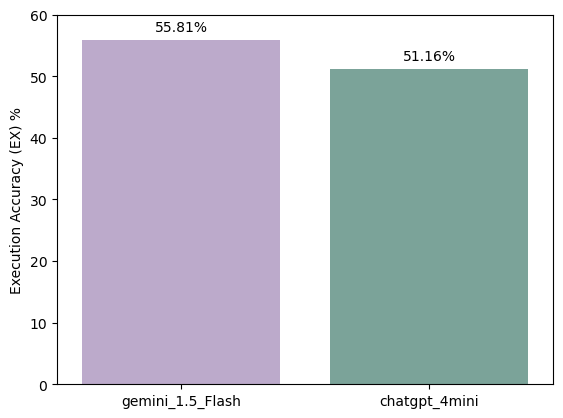

In [153]:
sns.barplot(df_zero_shot, x=df_zero_shot.index, y='total_EX', hue=df_zero_shot.index, palette=colors)
for i, value in enumerate(df_zero_shot['total_EX']):
    plt.annotate(f"{value:.2f}%", (i, value + 1), ha='center', va='bottom')
plt.ylabel('Execution Accuracy (EX) %')
plt.xlabel('')
plt.ylim(0, 60)
plt.show()

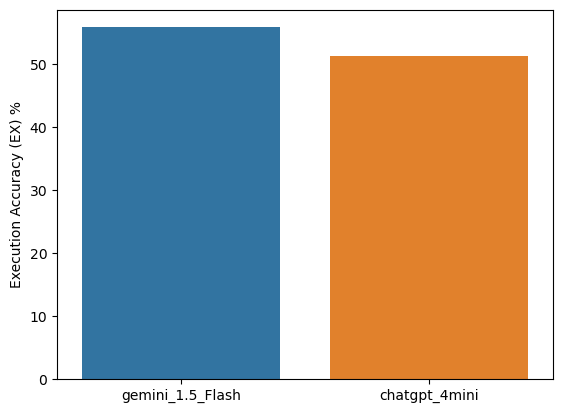

In [143]:
sns.barplot(df_zero_shot, x=df_zero_shot.index, y='total_EX', hue=df_zero_shot.index) #legend=False)
#plt.title('Zero-shot: Execution Accuracy (EX)')
plt.ylabel('Execution Accuracy (EX) %')
plt.xlabel('')
plt.show()


In [122]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_datos(datos1, datos2):
    # Etiquetas para los gráficos
    etiquetas = ['EX_by_diff', 'VA_by_diff', 'VES', 'EM']

    # Valores para los gráficos
    valores1 = [datos1['EX_by_diff']['total'], datos1['VA_by_diff']['total'], datos1['VES'], datos1['EM']]
    valores2 = [datos2['EX_by_diff']['total'], datos2['VA_by_diff']['total'], datos2['VES'], datos2['EM']]

    # Anchura de las barras
    anchura = 0.35

    # Posiciones de las barras
    posiciones = np.arange(len(etiquetas))

    # Gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(posiciones - anchura/2, valores1, width=anchura, label='Modelo 1')
    plt.bar(posiciones + anchura/2, valores2, width=anchura, label='Modelo 2')
    plt.xticks(posiciones, etiquetas)
    plt.xlabel('Métrica')
    plt.ylabel('Valor')
    plt.title('Comparación de métricas entre modelos')
    plt.legend()
    plt.show()

    # Gráfico de barras para EX_by_diff
    etiquetas_ex = ['simple', 'moderate', 'challenging', 'total']
    valores1_ex = [datos1['EX_by_diff']['simple'], datos1['EX_by_diff']['moderate'], datos1['EX_by_diff']['challenging'], datos1['EX_by_diff']['total']]
    valores2_ex = [datos2['EX_by_diff']['simple'], datos2['EX_by_diff']['moderate'], datos2['EX_by_diff']['challenging'], datos2['EX_by_diff']['total']]

    posiciones_ex = np.arange(len(etiquetas_ex))

    plt.figure(figsize=(10, 6))
    plt.bar(posiciones_ex - anchura/2, valores1_ex, width=anchura, label='Modelo 1')
    plt.bar(posiciones_ex + anchura/2, valores2_ex, width=anchura, label='Modelo 2')
    plt.xticks(posiciones_ex, etiquetas_ex)
    plt.xlabel('Dificultad')
    plt.ylabel('Valor')
    plt.title('Comparación de EX_by_diff entre modelos')
    plt.legend()
    plt.show()

    # Gráfico de barras para VA_by_diff
    etiquetas_va = ['simple', 'moderate', 'challenging', 'total']
    valores1_va = [datos1['VA_by_diff']['simple'], datos1['VA_by_diff']['moderate'], datos1['VA_by_diff']['challenging'], datos1['VA_by_diff']['total']]
    valores2_va = [datos2['VA_by_diff']['simple'], datos2['VA_by_diff']['moderate'], datos2['VA_by_diff']['challenging'], datos2['VA_by_diff']['total']]

    posiciones_va = np.arange(len(etiquetas_va))

    plt.figure(figsize=(10, 6))
    plt.bar(posiciones_va - anchura/2, valores1_va, width=anchura, label='Modelo 1')
    plt.bar(posiciones_va + anchura/2, valores2_va, width=anchura, label='Modelo 2')
    plt.xticks(posiciones_va, etiquetas_va)
    plt.xlabel('Dificultad')
    plt.ylabel('Valor')
    plt.title('Comparación de VA_by_diff entre modelos')
    plt.legend()
    plt.show()

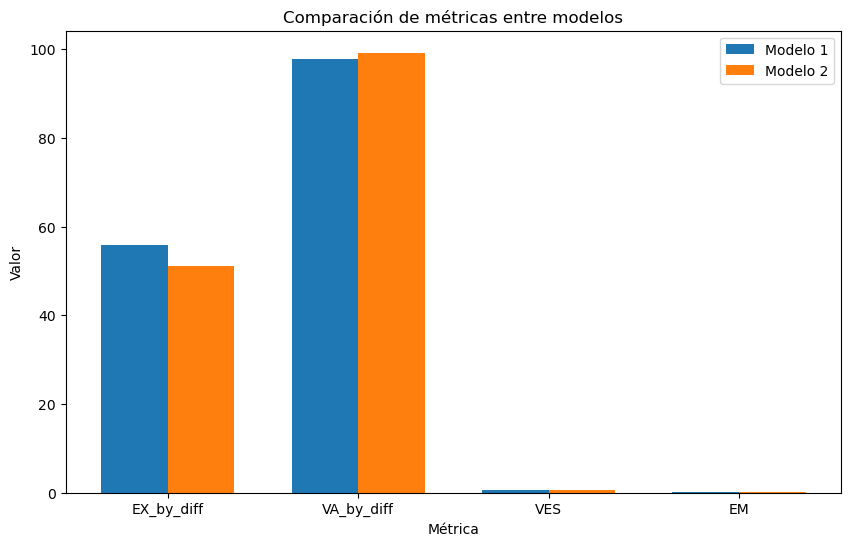

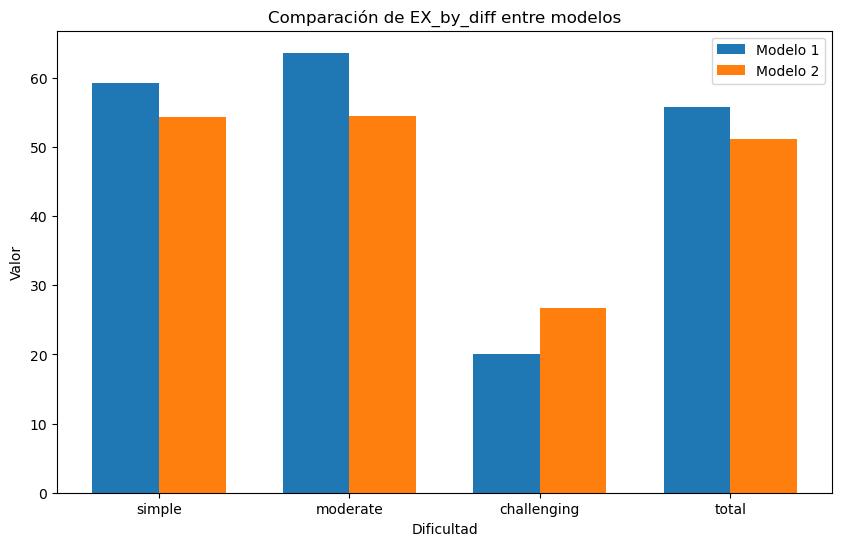

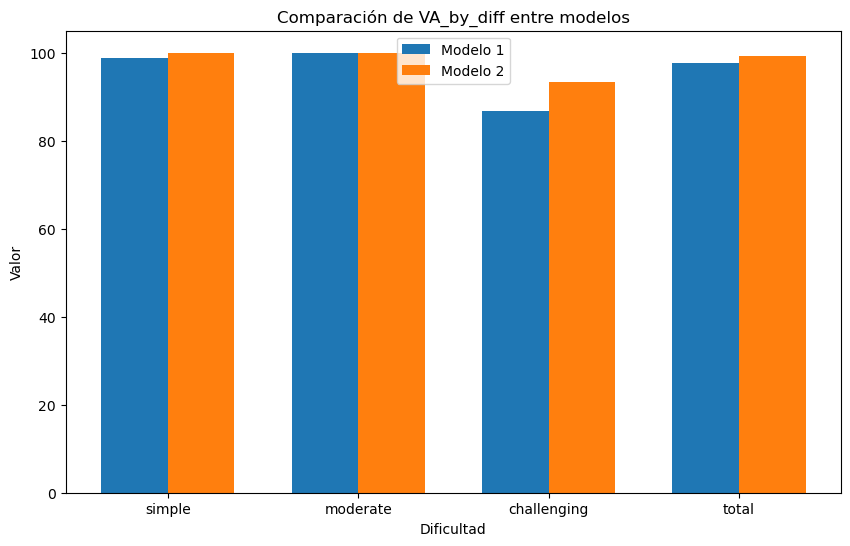

In [123]:
graficar_datos(metricas_gemini, metricas_chatgpt) #, 'gemini_1.5_Flash', 'chatgpt_4mini')